<a href="https://colab.research.google.com/github/charmdust/Hello-World-Hackathon-Hack-To-the-Future/blob/main/Test_set_best_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from transformers import AutoTokenizer, AutoModel
import torch

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import seaborn as sns

In [ ]:
# Upload csv file of senolytics datasets #embeddings_ChemBERTa-77M-MTR.csv
from google.colab import files

uploaded_files = files.upload()

Saving embeddings_ChemBERTa-77M-MTR.csv to embeddings_ChemBERTa-77M-MTR.csv
Saving list_of_compounds_for_computational_screening.csv to list_of_compounds_for_computational_screening.csv
Saving test_embeddings.csv to test_embeddings.csv


In [ ]:
# Senolytic embedding dataset
embeddings_df = pd.read_csv('embeddings_ChemBERTa-77M-MTR.csv', index_col=0)
embeddings_unlabelled_df= embeddings_df.drop(['senolytic'], axis=1)

In [ ]:
# Senolytic dataset - test set
test_df = pd.read_csv('list_of_compounds_for_computational_screening.csv')
test_df

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,1.763934,816.314286,19.388541,15.728578,15.728578,13.049575,8.787575,...,0,0,0,0,0,0,0,0,0,0.753438
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,1.880486,797.989385,15.319626,12.282905,12.282905,10.593172,7.390657,...,0,0,0,0,0,0,0,0,0,0.879020
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,2.396255,185.311799,8.276021,7.723234,7.723234,4.982999,4.663847,...,0,0,0,0,0,0,0,0,0,0.566800
3,(-)-Cotinine,Targetmol 3338,CN1[C@@H](CCC1=O)c1cccnc1,2.236360,309.960601,9.259149,7.603640,7.603640,6.287694,4.444035,...,0,0,0,0,0,0,0,0,0,0.647201
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,1.721352,1196.568791,23.153972,16.258499,16.258499,15.133938,9.330270,...,0,0,0,0,0,0,0,0,0,0.235487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,α-Terpineol,Selleck,CC1=CCC(CC1)C(C)(C)O,2.538576,162.201816,8.483128,7.723234,7.723234,4.999019,4.379255,...,0,0,0,0,0,0,0,0,0,0.575260
4336,β-Alanine,Selleck,NCCC(O)=O,2.831257,52.754888,4.991564,3.347026,3.347026,2.770056,1.689533,...,0,0,0,0,0,0,0,0,0,0.475392
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,2.119623,293.160171,11.052042,10.474691,10.474691,7.004837,6.338317,...,0,0,0,0,0,0,0,0,0,0.500562
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,1.695803,903.502499,24.396977,22.144179,22.144179,15.287200,13.412878,...,0,0,0,0,0,0,0,0,0,0.431968


## Get embeddings for test set

In [ ]:
smiles = test_df['SMILES'].astype(str).tolist()

In [ ]:
# Split into chunks as colab crashed with full dataset
smiles_1 = smiles[0:1500]
smiles_2 = smiles[1500:3000]
smiles_3 = smiles[3000:]

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def gen_embeddings (model, tokenizer, smiles):
    #Tokenize sentences
    encoded_input = tokenizer(smiles, padding=True, truncation=True, max_length=128, return_tensors='pt')

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    return mean_pooling(model_output, encoded_input['attention_mask'])

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

#tokenizer_2 = AutoTokenizer.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")
#model_2 = AutoModel.from_pretrained("seyonec/SMILES_tokenized_PubChem_shard00_160k")


chemBERTa_2_test_embeddings_1 = gen_embeddings(model, tokenizer,smiles_1)

#st_sentence_embeddings = gen_embeddings(model_2, tokenizer_2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
chemBERTa_2_test_embeddings_2 = gen_embeddings(model, tokenizer,smiles_2)

In [ ]:
chemBERTa_2_test_embeddings_3 = gen_embeddings(model, tokenizer,smiles_3)

In [ ]:
embeddings_test_df_1 = pd.DataFrame(chemBERTa_2_test_embeddings_1)
embeddings_test_df_1

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.015999,0.447090,-0.064498,0.007834,0.249663,-0.129743,0.019870,0.388460,0.460315,0.333144,...,-0.192478,-0.028564,0.361139,-0.191047,0.421456,0.255147,-0.405248,0.007735,-0.202822,-0.565957
1,-0.162281,-0.168639,-0.056570,-0.053624,-0.232558,-0.021849,-0.595615,0.446200,1.155252,0.770201,...,0.242932,-0.382648,0.381507,-0.381017,0.865323,0.397636,0.072945,-0.317535,-0.831613,-0.976863
2,-0.217092,-0.015165,-0.008606,0.019475,-0.095752,0.140221,-0.303309,0.368919,0.989612,0.566312,...,-0.069499,0.251827,0.450819,0.067432,0.392029,0.217081,-0.002524,-0.184265,-0.501855,-0.562045
3,0.082067,-0.036083,0.000781,0.224541,-0.286423,0.087893,-0.159557,0.388663,1.253454,0.958874,...,0.346133,-0.217270,0.527730,-0.162094,0.553649,0.563702,-0.127482,-0.122900,-0.797646,-0.770542
4,-0.358998,0.603541,-0.126494,-0.100830,0.640436,-0.605037,0.255124,0.085224,0.408842,0.334106,...,0.236037,0.271649,0.386647,0.029748,0.434413,0.024351,-0.725533,0.225216,-0.016629,-0.597636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-0.042812,-0.055931,-0.083928,-0.116147,0.094486,-0.011687,-0.336828,0.157682,-0.015651,0.612670,...,-0.388692,-0.361223,0.442881,-0.476847,0.558131,0.014775,0.216589,0.283854,-0.350803,-0.482452
1496,-0.121931,-0.090184,-0.042331,-0.228506,-0.216776,0.074839,-0.681562,0.605939,0.995063,0.924971,...,0.153192,-0.230655,0.275917,-0.392969,0.727698,0.253267,0.093154,-0.052828,-0.637587,-0.608289
1497,-0.196772,0.284384,-0.083806,-0.356320,-0.203018,0.124803,-0.206594,0.373017,0.803866,0.544679,...,-0.203244,0.155003,0.558742,-0.014099,0.356620,0.524395,-0.341758,-0.163389,-0.533205,-1.081743
1498,0.096926,0.221390,-0.012452,0.499217,-0.229238,0.042618,-0.001573,0.468268,1.186432,1.390496,...,0.401185,0.088484,0.578144,0.416028,0.614970,0.334874,-0.359887,-0.170395,-0.749301,-0.816329


In [ ]:
embeddings_test_df_2 = pd.DataFrame(chemBERTa_2_test_embeddings_2)
embeddings_test_df_3 = pd.DataFrame(chemBERTa_2_test_embeddings_3)

In [ ]:
embeddings_test_df = pd.concat([embeddings_test_df_1, embeddings_test_df_2, embeddings_test_df_3])

In [ ]:
embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.015999,0.447090,-0.064498,0.007834,0.249663,-0.129743,0.019870,0.388460,0.460315,0.333144,...,-0.192478,-0.028564,0.361139,-0.191047,0.421456,0.255147,-0.405248,0.007735,-0.202822,-0.565957
1,-0.162281,-0.168639,-0.056570,-0.053624,-0.232558,-0.021849,-0.595615,0.446200,1.155252,0.770201,...,0.242932,-0.382648,0.381507,-0.381017,0.865323,0.397636,0.072945,-0.317535,-0.831613,-0.976863
2,-0.217092,-0.015165,-0.008606,0.019475,-0.095752,0.140221,-0.303309,0.368919,0.989612,0.566312,...,-0.069499,0.251827,0.450819,0.067432,0.392029,0.217081,-0.002524,-0.184265,-0.501855,-0.562045
3,0.082067,-0.036083,0.000781,0.224541,-0.286423,0.087893,-0.159557,0.388663,1.253454,0.958874,...,0.346133,-0.217270,0.527730,-0.162094,0.553649,0.563702,-0.127482,-0.122900,-0.797646,-0.770542
4,-0.358998,0.603541,-0.126494,-0.100830,0.640436,-0.605037,0.255124,0.085224,0.408842,0.334106,...,0.236037,0.271649,0.386647,0.029748,0.434413,0.024351,-0.725533,0.225216,-0.016629,-0.597636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,-0.074408,0.152514,-0.019172,-0.041170,-0.094130,-0.026386,-0.221204,0.530042,0.981029,0.789312,...,0.122846,0.033057,0.469565,0.051910,0.478696,0.282265,-0.152491,-0.087252,-0.533910,-0.492262
1336,-0.251557,0.256073,-0.000195,-0.075419,-0.288665,0.140940,0.216912,0.194855,0.480798,-0.009994,...,-0.011760,-0.238926,0.459643,0.099511,0.221043,0.170666,-0.305677,-0.190266,-0.347147,-0.367335
1337,-0.052847,-0.104021,-0.009910,-0.086056,-0.140885,-0.062344,-0.471855,0.328054,1.006909,0.818338,...,-0.015477,0.053431,0.386559,-0.087835,0.300453,0.216072,0.118490,-0.101798,-0.360060,-0.569058
1338,-0.412817,0.024246,-0.045485,-0.156406,-0.094835,0.133908,-0.462214,0.215728,1.085659,0.889012,...,-0.432041,0.269942,0.501222,-0.220169,0.351724,0.067449,0.315461,0.107205,-0.397632,-0.553345


In [ ]:
# Save dataframe to csv
embeddings_test_df.to_csv('test_embeddings.csv', index=True)

## PCA

In [ ]:
# load embeddings#

embeddings_test_df = pd.read_csv('test_embeddings.csv', index_col=0)
embeddings_test_df


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,0.015999,0.447090,-0.064498,0.007834,0.249663,-0.129743,0.019870,0.388460,0.460315,0.333144,...,-0.192478,-0.028564,0.361139,-0.191047,0.421456,0.255147,-0.405248,0.007735,-0.202822,-0.565957
1,-0.162281,-0.168639,-0.056570,-0.053624,-0.232558,-0.021849,-0.595615,0.446200,1.155252,0.770201,...,0.242932,-0.382648,0.381507,-0.381017,0.865323,0.397636,0.072945,-0.317535,-0.831613,-0.976863
2,-0.217092,-0.015165,-0.008606,0.019475,-0.095752,0.140221,-0.303309,0.368919,0.989612,0.566312,...,-0.069499,0.251827,0.450819,0.067432,0.392029,0.217081,-0.002524,-0.184265,-0.501856,-0.562045
3,0.082067,-0.036083,0.000781,0.224541,-0.286423,0.087893,-0.159557,0.388663,1.253454,0.958874,...,0.346133,-0.217270,0.527730,-0.162094,0.553649,0.563702,-0.127482,-0.122900,-0.797646,-0.770542
4,-0.358998,0.603541,-0.126494,-0.100830,0.640436,-0.605037,0.255124,0.085224,0.408842,0.334106,...,0.236037,0.271649,0.386647,0.029748,0.434413,0.024351,-0.725534,0.225216,-0.016629,-0.597636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,-0.074408,0.152514,-0.019172,-0.041170,-0.094130,-0.026386,-0.221204,0.530042,0.981029,0.789312,...,0.122846,0.033057,0.469565,0.051910,0.478696,0.282265,-0.152491,-0.087252,-0.533910,-0.492262
1336,-0.251557,0.256073,-0.000195,-0.075419,-0.288665,0.140940,0.216912,0.194855,0.480798,-0.009994,...,-0.011760,-0.238926,0.459643,0.099511,0.221043,0.170666,-0.305677,-0.190266,-0.347147,-0.367335
1337,-0.052847,-0.104021,-0.009910,-0.086056,-0.140885,-0.062344,-0.471855,0.328054,1.006909,0.818338,...,-0.015477,0.053431,0.386559,-0.087835,0.300453,0.216072,0.118490,-0.101798,-0.360060,-0.569058
1338,-0.412817,0.024246,-0.045485,-0.156406,-0.094835,0.133908,-0.462214,0.215728,1.085659,0.889012,...,-0.432042,0.269942,0.501222,-0.220169,0.351724,0.067449,0.315461,0.107205,-0.397632,-0.553345


In [ ]:
# Scale dataset https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
std_scaler = StandardScaler()
std_scaler.fit(embeddings_unlabelled_df)
scaled_embeddings_df = std_scaler.transform(embeddings_unlabelled_df)
scaled_test_df = std_scaler.transform(embeddings_test_df)




In [ ]:
# Choose 52 to explain 90% variance of training data
pca = PCA(n_components=52)
pca.fit(scaled_embeddings_df)
pca_transformed_embeddings = pca.transform(scaled_embeddings_df)
pca_test_embeddings = pca.transform(scaled_test_df)

In [ ]:
pca_transformed_embeddings_df = pd.DataFrame(pca_transformed_embeddings)
pca_test_embeddings_df = pd.DataFrame(pca_test_embeddings)
pca_test_embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,14.462099,-2.509456,-3.565518,-4.358227,-1.306718,-6.017692,1.314764,-1.169258,-0.109317,1.282284,...,-1.453663,0.064932,-0.509477,0.947620,0.994520,-0.173978,1.517514,1.263019,1.038755,-0.419309
1,-12.448546,2.441102,-2.880943,-2.138210,1.926592,2.103481,-4.514025,1.214933,3.622077,-3.801412,...,-0.264401,0.424026,0.102001,-0.851517,-0.977869,0.680115,1.145947,0.207854,0.376182,0.303066
2,0.813190,-4.945495,1.215400,-6.177967,-2.510112,0.587790,-2.886359,-2.545409,-2.664223,0.099349,...,0.876955,-0.652685,-0.163837,-0.681583,0.233723,-0.640636,0.074668,0.597652,-0.617710,0.070147
3,-2.290944,-1.756744,1.960060,-10.101435,0.205193,2.407785,0.124273,-1.109965,2.497804,-1.671012,...,0.280451,0.455067,0.656380,0.739502,0.792212,-0.510001,-0.191673,0.277648,0.466322,-0.561857
4,18.387909,-4.416875,-5.403558,4.977582,1.015130,0.021157,-6.004884,8.683226,-0.431096,2.280160,...,1.739123,1.624633,0.341306,0.641247,2.187689,1.879083,-0.934772,0.984719,-0.089270,0.562155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,2.742460,-1.475390,0.285700,-7.769209,-0.862422,0.268997,-1.442588,-1.569673,-2.580723,0.732708,...,0.710393,-0.029791,1.202458,-1.364824,1.735864,-1.086662,1.122586,0.426555,1.186258,1.414388
4336,11.852829,9.099861,4.857801,-9.569574,0.778912,1.456533,-0.831846,-2.722682,-6.624447,2.091103,...,-0.269722,0.172668,-0.070927,0.213537,0.143004,1.121223,1.496109,-0.333797,0.223766,0.861092
4337,-0.819715,-3.320378,-2.576521,-6.064727,-1.414494,-1.134016,-2.615895,-2.981849,1.252471,1.110965,...,0.740592,-0.178136,-0.173379,-1.406826,1.375948,-1.001325,-0.119174,0.101236,-0.151766,0.258671
4338,-2.254865,-10.431519,-4.421738,0.768781,-3.012590,-2.905828,-4.169582,-4.686741,-2.982584,0.752503,...,1.202262,-1.333247,-1.264598,-1.680177,0.829358,-0.779252,-0.582121,0.079051,-0.943770,0.254439


In [ ]:
X_train = pca_transformed_embeddings_df
y_train = embeddings_df['senolytic']

In [ ]:
X_test = pca_test_embeddings_df


In [ ]:
# Shuffle dataset

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test = shuffle(X_test, random_state=42)


## Best model

### KNN

In [ ]:

best_params_knn = {'weights': 'distance', 'n_neighbors': 5, 'algorithm': 'brute'}

In [ ]:
knn_best = KNeighborsClassifier(**best_params_knn)

knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

In [ ]:
y_pred.sum()

34

In [ ]:
test_df['prediction knn'] = y_pred

In [ ]:
test_df_predicted_knn = test_df[test_df['prediction knn']==1]

In [ ]:
test_df_predicted_knn

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction knn
108,20(R)-Propanaxadiol,Targetmol 3338,C\C(C)=C/CC[C@@](C)(O)[C@H]1CC[C@]2(C)[C@@H]1[...,1.225638,1368.350456,40.628663,34.251045,34.251045,25.583261,20.863808,...,0,0,0,0,0,0,0,0,0.114795,1
396,Anisindione,Selleck,COC1=CC=C(C=C1)C2C(=O)C3=C(C=CC=C3)C2=O,2.032978,620.949193,13.405413,10.420897,10.420897,9.219545,6.035364,...,0,0,0,0,0,0,0,0,0.771773,1
457,Ascomycin (FK520),Selleck,CCC1/C=C(C)/CC(C)CC(OC)C2OC(O)(C(C)CC2OC)C(=O)...,1.763743,1430.854500,41.482034,35.108624,35.108624,26.483058,20.776667,...,0,0,0,0,0,0,0,0,0.195726,1
470,Astragaloside A,Targetmol 3338,CC(C)(O)[C@H]1CC[C@](C)(O1)[C@H]1[C@@H](O)C[C@...,1.148792,1455.821545,40.051313,33.581943,33.581943,25.510111,20.867657,...,0,0,0,0,0,0,0,0,0.162354,1
501,Avermectin B1,Selleck,CCC(C)C1OC2(CC3CC(C\C=C(C)\C(OC4CC(OC)C(OC5CC(...,1.182608,1725.637571,44.672269,38.215876,38.215876,29.497426,22.859695,...,0,0,0,0,0,0,0,0,0.210064,1
988,Chikusetsusaponin IVa,Targetmol 3338,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]1([C@@H]2CC=C2...,1.155946,1562.792020,41.128663,33.965627,33.965627,25.986343,20.790423,...,0,0,0,0,0,0,0,0,0.109716,1
1172,Cyasterone,Targetmol 3338,O1C(=O)[C@H]([C@@H]([C@H]1C)C[C@H]([C@@](C)([C...,1.441524,1005.865684,27.292164,22.684063,22.684063,17.074894,14.029735,...,0,0,0,0,0,0,0,0,0.353607,1
1365,Dioscin,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,0.915995,1592.540511,43.498542,36.478276,36.478276,28.900395,23.217479,...,0,0,0,0,0,0,0,0,0.168241,1
1366,Diosgenin,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@@H](...,1.282199,736.390210,20.888541,19.530930,19.530930,14.267258,12.960682,...,0,0,0,0,0,0,0,0,0.515749,1
1451,Echinacoside,Selleck,CC1OC(OC2C(O)C(OCCC3=CC(=C(O)C=C3)O)OC(COC4OC(...,1.433756,1605.617057,40.136735,29.240033,29.240033,26.085534,17.230522,...,0,0,0,0,0,0,0,0,0.054057,1


In [ ]:
true_senolytics = ['Periplocin', 'Oleandrin', 'Ginkgetin']

for senolytic in true_senolytics:
  if senolytic in list(test_df_predicted_knn['Name']):
    print(senolytic)

Periplocin
Oleandrin


In [ ]:
y_predict_proba_knn = knn_best.predict_proba(X_test)

In [ ]:
test_df['prediction probability knn'] = y_predict_proba_knn[:,1]

In [ ]:
test_df_predictions = test_df[['Name', 'Library', 'SMILES', 'prediction knn', 'prediction probability knn']]
test_df_predictions

,Name,Library,SMILES,prediction knn,prediction probability knn
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,0,0.000000
1,(-)-Blebbistatin,Targetmol 3338,Cc1ccc2N=C3N(CC[C@@]3(O)C(=O)c2c1)c1ccccc1,0,0.000000
2,(-)-Borneol,Selleck,CC1(C)C2CCC1(C)C(O)C2,0,0.000000
3,(-)-Cotinine,Targetmol 3338,CN1[C@@H](CCC1=O)c1cccnc1,0,0.000000
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,0,0.213154
...,...,...,...,...,...
4335,α-Terpineol,Selleck,CC1=CCC(CC1)C(C)(C)O,0,0.000000
4336,β-Alanine,Selleck,NCCC(O)=O,0,0.000000
4337,β-Caryophyllene,Selleck,CC/1=C\CCC(=C)C2CC(C)(C)C2CC1,0,0.000000
4338,β-Elemonic Acid,Targetmol 3338,C\C(C)=C/CC[C@@H]([C@@H]1CC[C@]2(C)C3=C(CC[C@@...,0,0.000000


In [ ]:
test_df_predictions.sort_values(by=['prediction probability knn'], ascending=False)

,Name,Library,SMILES,prediction knn,prediction probability knn
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1,0.822756
2677,Momordin Ic,Targetmol 3338,[C@@H]1([C@@H]([C@H]([C@@H]([C@@H](O1)O[C@H]1C...,1,0.810752
3886,Tenacissoside H,Targetmol 3338,CCC(C)C(=O)O[C@@H]1[C@@H](OC(C)=O)[C@]2(C)[C@@...,1,0.800790
2880,Nystatin (Fungicidin),Selleck,CC1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)CC2(O)CC(O)C...,1,0.623127
988,Chikusetsusaponin IVa,Targetmol 3338,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]1([C@@H]2CC=C2...,1,0.612562
...,...,...,...,...,...
1515,Epiandrosterone,Selleck,CC12CCC(O)CC1CCC3C2CCC4(C)C3CCC4=O,0,0.000000
1516,Epiberberine,Targetmol 3338,COC1=C(C=C2C(=C1)CC[N+]3=C2C=C4C=CC5=C(C4=C3)O...,0,0.000000
1518,Epinastine HCl,Selleck,Cl.NC1=NCC2N1C3=CC=CC=C3CC4=CC=CC=C24,0,0.000000
1519,Epinephrine bitartrate,Selleck,CNCC(O)C1=CC(=C(O)C=C1)O.OC(C(O)C(O)=O)C(O)=O,0,0.000000


In [ ]:
test_df_predictions[test_df_predictions['Name'].isin(true_senolytics)]

,Name,Library,SMILES,prediction knn,prediction probability knn
1800,Ginkgetin,Targetmol 3338,COc1cc(O)c2c(c1)oc(cc2=O)-c1ccc(OC)c(c1)-c1c(O...,0,0.000000
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1,0.822756
3078,Periplocin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C)[C@H]4CC[C@]5(...,1,0.583539


In [ ]:
test_df_predictions[test_df_predictions['prediction probability knn']>0.4].sort_values(by=['prediction probability knn'], ascending=False)

,Name,Library,SMILES,prediction knn,prediction probability knn
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1,0.822756
2677,Momordin Ic,Targetmol 3338,[C@@H]1([C@@H]([C@H]([C@@H]([C@@H](O1)O[C@H]1C...,1,0.810752
3886,Tenacissoside H,Targetmol 3338,CCC(C)C(=O)O[C@@H]1[C@@H](OC(C)=O)[C@]2(C)[C@@...,1,0.800790
2880,Nystatin (Fungicidin),Selleck,CC1OC(=O)CC(O)CC(O)CC(O)CCC(O)C(O)CC2(O)CC(O)C...,1,0.623127
988,Chikusetsusaponin IVa,Targetmol 3338,C[C@]12CC[C@@H](C([C@@H]1CC[C@@]1([C@@H]2CC=C2...,1,0.612562
3628,Silymarin,Selleck,COC1=CC(=CC=C1O)C2OC3=CC=C(C=C3OC2CO)C4OC5=C(C...,1,0.611276
3590,Selamectin,Selleck,COC1CC(OC(C)C1O)OC/2C(C)\C=C\C=C\3COC4/C(=N/O)...,1,0.611225
1172,Cyasterone,Targetmol 3338,O1C(=O)[C@H]([C@@H]([C@H]1C)C[C@H]([C@@](C)([C...,1,0.609130
3420,Rifampin,Selleck,COC1\C=C\OC2(C)OC3=C(C2=O)C4=C(O)C(=C(NC(=O)\C...,1,0.608326
3217,Polyphyllin I,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,1,0.608314


In [ ]:
test_df_predictions[test_df_predictions['prediction probability knn']!=0.0].sort_values(by=['prediction probability knn'], ascending=True).head(20)

,Name,Library,SMILES,prediction knn,prediction probability knn
2597,Midecamycin,Selleck,CCC(=O)OC1CC(=O)OC(C)C/C=C/C=C/C(O)C(C)CC(CC=O...,0,0.014797
4168,Vandetanib,Targetmol 3338,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,0,0.078993
230,Acetylspiramycin (ASPM),Selleck,COC1C(CC(=O)OC(C)C/C=C/C=C/C(OC2CCC(C(C)O2)N(C...,0,0.102705
2409,Lovastatin,Selleck,CCC(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC(=O...,0,0.129183
3337,Quinacrine 2HCl,Selleck,Cl.Cl.CCN(CC)CCCC(C)NC1=C2C=C(OC)C=CC2=NC3=CC(...,0,0.146070
3713,Spiramycin,Selleck,COC1C(O)CC(=O)OC(C)C/C=C/C=C/C(OC2CCC(C(C)O2)N...,0,0.147113
4162,Valganciclovir HCl,Selleck,Cl.CC(C)C(N)C(=O)OCC(CO)OCN1C=NC2C1N=C(N)NC2=O,0,0.150732
3630,Simvastatin,Selleck,CCC(C)(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC...,0,0.154425
2194,Kaempferitrin,Targetmol 3338,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)Oc1cc(c2c(...,0,0.155748
4213,Vitexicarpin,Targetmol 3338,COC1=C(C=C(C=C1)C2=C(C(=O)C3=C(C(=C(C=C3O2)OC)...,0,0.162605


In [ ]:
# Since log plot cannot be calculated for probability=0, change 0 probabilities to 0.0001 which is much smaller than smallest non zro value in dataset
test_df_predictions['prediction probability knn'] = test_df_predictions['prediction probability knn'].apply(lambda x: 0.001 if x == 0.0 else x)

<ipython-input-67-74dff3174098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_predictions['prediction probability knn'] = test_df_predictions['prediction probability knn'].apply(lambda x: 0.001 if x == 0.0001 else x)


In [ ]:
test_df_predictions.sort_values(by=['prediction probability knn'], ascending=True).head(20)

,Name,Library,SMILES,prediction knn,prediction probability knn
0,(-)-Arctigenin,Selleck,COC1=C(O)C=CC(=C1)CC2C(COC2=O)CC3=CC=C(OC)C(=C...,0,0.001
2807,Nilotinib,Targetmol 3338,Cc1cn(cn1)-c1cc(NC(=O)c2ccc(C)c(Nc3nccc(n3)-c3...,0,0.001
2808,Nilutamide,Selleck,CC1(C)NC(=O)N(C2=CC=C(C(=C2)C(F)(F)F)[N+]([O-]...,0,0.001
2809,Nilvadipine,Selleck,COC(=O)C1=C(NC(=C(C1C2=CC=CC(=C2)[N+]([O-])=O)...,0,0.001
2810,Nimesulide,Selleck,C[S](=O)(=O)NC1=C(OC2=CC=CC=C2)C=C(C=C1)[N+]([...,0,0.001
2811,Nimodipine,Selleck,COCCOC(=O)C1=C(C)NC(=C(C1C2=CC=CC(=C2)[N+]([O-...,0,0.001
2812,Nimorazole,Targetmol 3338,[O-][N+](=O)C1=CN=CN1CCN1CCOCC1,0,0.001
2813,Nimustine Hydrochloride,Selleck,Cl.CC1=NC=C(CNC(=O)N(CCCl)N=O)C(=N1)N,0,0.001
2814,Nintedanib,Targetmol 3338,COC(=O)c1ccc2c(NC(=O)\C2=C(/Nc2ccc(cc2)N(C)C(=...,0,0.001
2815,Niraparib,Targetmol 3338,c1(cccc2c1nn(c2)c1ccc(cc1)[C@H]1CNCCC1)C(=O)N,0,0.001


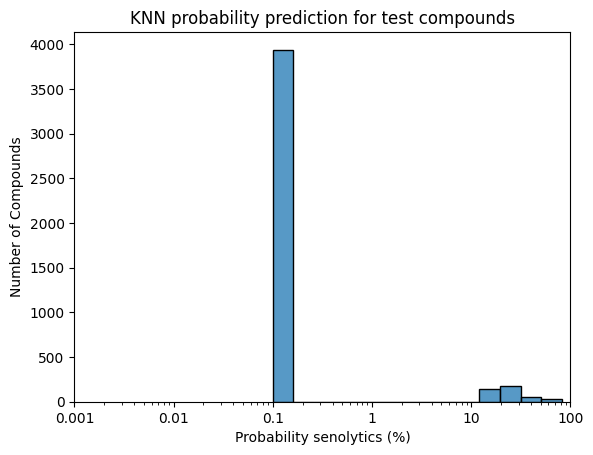

In [ ]:
# reduce bin size

from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df_predictions["prediction probability knn"],
    log_scale=(True, False))

plt.title("KNN probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()

In [ ]:
test_df_predictions_not_zero = test_df_predictions[test_df_predictions['prediction probability knn']!=0.001]

In [ ]:
test_df_predictions_not_zero

,Name,Library,SMILES,prediction knn,prediction probability knn
4,(-)-Epicatechin gallate,Selleck,OC1=CC2=C(CC(OC(=O)C3=CC(=C(O)C(=C3)O)O)C(O2)C...,0,0.213154
12,(-)Epicatechin,Selleck,OC1CC2=C(OC1C3=CC(=C(O)C=C3)O)C=C(O)C=C2O,0,0.168602
18,(+)-Catechin,Selleck,OC1CC2=C(OC1C3=CC(=C(O)C=C3)O)C=C(O)C=C2O,0,0.168602
75,17α-Estradiol,Targetmol 3338,c1cc(cc2CC[C@H]3[C@@H]4CC[C@H]([C@]4(CC[C@@H]3...,0,0.257419
76,1H-Pyrazole-3-acetamide,Targetmol 3338,CCN(CCO)CCCOc1ccc2c(Nc3cc(CC(=O)Nc4cccc(F)c4)[...,0,0.209990
...,...,...,...,...,...
4228,Voxtalisib,Targetmol 3338,CCN1C(=O)C(=CC2=C(C)N=C(N)N=C12)C1=CC=NN1,0,0.203751
4246,Wedelolactone,Selleck,COC1=CC2=C(C(=C1)O)C3=C(C(=O)O2)C4=C(O3)C=C(O)...,0,0.195754
4268,WZB117,Targetmol 3338,Oc1cc(ccc1)C(=O)Oc1c(OC(=O)c2cc(O)ccc2)cccc1F,0,0.171796
4332,Zotarolimus,Targetmol 3338,[H][C@@]12CCCCN1C(=O)C(=O)[C@]1(O)O[C@@H](CC[C...,1,0.529782


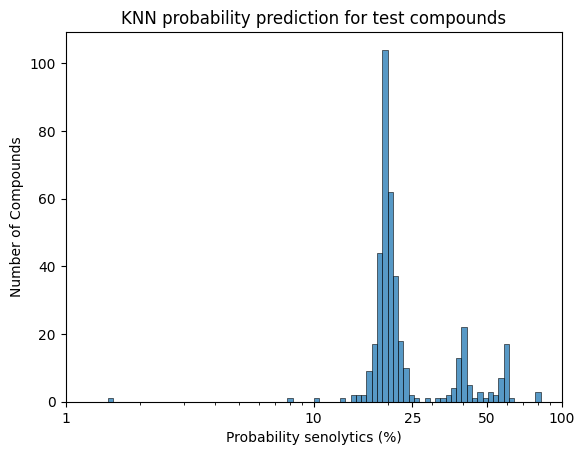

In [ ]:
# reduce bin size

from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df_predictions_not_zero, x=100*test_df_predictions_not_zero["prediction probability knn"],
    log_scale=(True, False))

plt.title("KNN probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([1, 100])
# Define the desired tick positions and labels
tick_positions = [1, 10, 25, 50, 100]
tick_labels = ['1', '10', '25', '50','100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()

In [ ]:
print(str(100-round(len(test_df_predictions_not_zero)/len(test_df_predictions)*100,2)) + "% of compounds are predicted as zero")

90.76% of compounds are predicted as zero


### XGBoost

In [ ]:
best_params_xgb = {'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.9}

In [ ]:
xgb_best = xgb.XGBClassifier(random_state=42,  **best_params_xgb)#, scale_pos_weight = len(embeddings_df[embeddings_df['senolytic']==0])/len(embeddings_df[embeddings_df['senolytic']==1]))

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)



In [ ]:
sum(y_pred)

17

In [ ]:
y_predict_proba = xgb_best.predict_proba(X_test)

In [ ]:
test_df_predictions['prediction probability xgboost'] = y_predict_proba[:,1]

<ipython-input-98-b89e65ae295a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_predictions['prediction probability xgboost'] = y_predict_proba[:,1]


In [ ]:
test_df_predictions.sort_values(by=['prediction probability xgboost'], ascending=False)

,Name,Library,SMILES,prediction knn,prediction probability knn,prediction probability xgboost
3967,Timosaponin AIII,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC[C@@H]5C[C@...,1,0.603362,0.875040
2378,Liriopesides B,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,1,0.602097,0.824617
459,Asiatic acid,Targetmol 3338,C[C@@H]1CC[C@@]2(CC[C@@]3(C(=CC[C@H]4[C@]3(CC[...,0,0.397163,0.817258
369,Amphotericin B,Selleck,CC1OC(OC/2CC3OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC...,0,0.466267,0.796615
1380,Dirithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,0,0.216972,0.768936
...,...,...,...,...,...,...
2253,L-carnitine,Selleck,C[N+](C)(C)CC(O)CC([O-])=O,0,0.001000,0.000017
2275,L-serine,Selleck,NC(CO)C(O)=O,0,0.001000,0.000011
50,(R)-Serine,Selleck,NC(CO)C(O)=O,0,0.001000,0.000011
1394,DL-Serine,Selleck,NC(CO)C(O)=O,0,0.001000,0.000011


In [ ]:
test_df_predictions[test_df_predictions['Name'].isin(true_senolytics)]


,Name,Library,SMILES,prediction knn,prediction probability knn,prediction probability xgboost
1800,Ginkgetin,Targetmol 3338,COc1cc(O)c2c(c1)oc(cc2=O)-c1ccc(OC)c(c1)-c1c(O...,0,0.001000,0.001933
2911,Oleandrin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@@]3(C)[C@H](CC[C@@H...,1,0.822756,0.379037
3078,Periplocin,Targetmol 3338,CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C)[C@H]4CC[C@]5(...,1,0.583539,0.102814


In [ ]:
test_df[test_df['prediction probability xgboost']>0.4].sort_values(by=['prediction probability xgboost'], ascending=False)

,Name,Library,SMILES,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,qed,prediction knn,prediction probability knn,prediction probability xgboost
3967,Timosaponin AIII,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC[C@@H]5C[C@...,9.417813e-01,1262.449167,36.904684,31.242028,31.242028,24.740022,20.299410,...,0,0,0,0,0,0,0.193594,1,0.603362,0.875040
2378,Liriopesides B,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,1.075221e+00,1320.626585,36.360714,31.043738,31.043738,24.084733,19.802032,...,0,0,0,0,0,0,0.234233,1,0.602097,0.824617
459,Asiatic acid,Targetmol 3338,C[C@@H]1CC[C@@]2(CC[C@@]3(C(=CC[C@H]4[C@]3(CC[...,1.621932e+00,929.707645,25.767220,22.679866,22.679866,16.226505,14.137020,...,0,0,0,0,0,0,0.408691,0,0.397163,0.817258
369,Amphotericin B,Selleck,CC1OC(OC/2CC3OC(O)(CC(O)CC(O)C(O)CCC(O)CC(O)CC...,1.859385e+00,1665.867991,48.431782,37.578252,37.578252,30.615496,22.317848,...,0,0,0,0,0,0,0.173524,0,0.466267,0.796615
1380,Dirithromycin,Selleck,CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(O...,1.832795e+00,1292.255163,43.490470,37.583253,37.583253,27.019166,21.352388,...,0,0,0,0,2,0,0.141732,0,0.216972,0.768936
4334,α-Hederin,Selleck,CC1OC(OC2C(O)C(O)COC2OC3CCC4(C)C(CCC5(C)C4CC=C...,1.150319e+00,1436.892161,38.681069,32.739922,32.739922,24.687632,20.221546,...,0,0,0,0,0,0,0.154514,0,0.373508,0.732240
3715,Spirostan-3-ol,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CCC5CC(O)CC[C...,1.258571e+00,683.595663,20.888541,19.738037,19.738037,14.267258,13.265377,...,0,0,0,0,0,0,0.542748,0,0.406572,0.689519
2769,Nemiralisib (GSK2269557),Selleck,CC(C)N1CCN(CC1)CC2=CN=C(O2)C3=CC(=CC4=C3C=N[NH...,1.318698e+00,1402.738373,22.363232,19.006139,19.006139,16.153000,11.606203,...,0,0,0,0,0,0,0.406817,0,0.403576,0.685273
3690,Solamargine,Targetmol 3338,C[C@H]1[C@H]2[C@H](C[C@H]3[C@@H]4CC=C5C[C@H](C...,9.159949e-01,1597.937153,43.498542,36.570028,36.570028,28.900395,23.328233,...,0,0,0,0,0,0,0.161126,1,0.589676,0.669240
3490,Ruscogenin,Selleck,CC1CCC2(OC1)OC3CC4C5CC=C6CC(O)CC(O)C6(C)C5CCC4...,1.294549e+00,769.198123,21.758784,19.848387,19.848387,14.687978,13.062251,...,0,0,0,0,0,0,0.547787,0,0.389902,0.666739


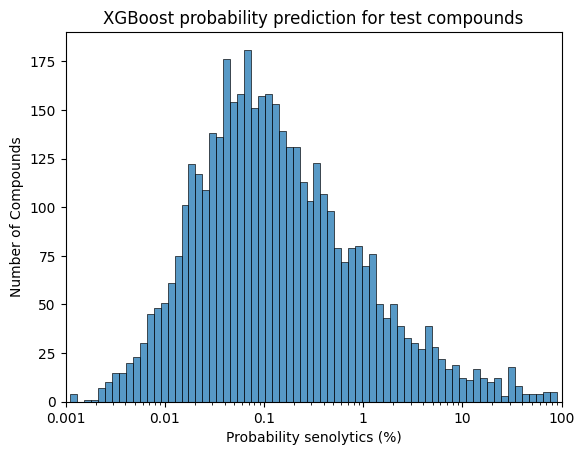

In [ ]:
# reduce bin size

from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["prediction probability xgboost"],
    log_scale=True, binwidth=0.07)

plt.title("XGBoost probability prediction for test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()